In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data= pd.read_csv('D:\Datascience\shampoo\shampoo.csv')

In [3]:
data.shape

(37, 2)

In [4]:
data.head()

,Month,Sales of shampoo over a three year period
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [5]:
data=data.rename(columns={'Sales of shampoo over a three year period': 'Sales'}) # renaming the sales column

In [6]:
data=data.dropna(axis=0)

In [7]:
data['Date']=pd.to_datetime('190'+data.Month,format='%Y-%m')

In [8]:
data=data.drop('Month', axis=1)

In [9]:
data.set_index('Date', inplace=True)

C:\Users\hp\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


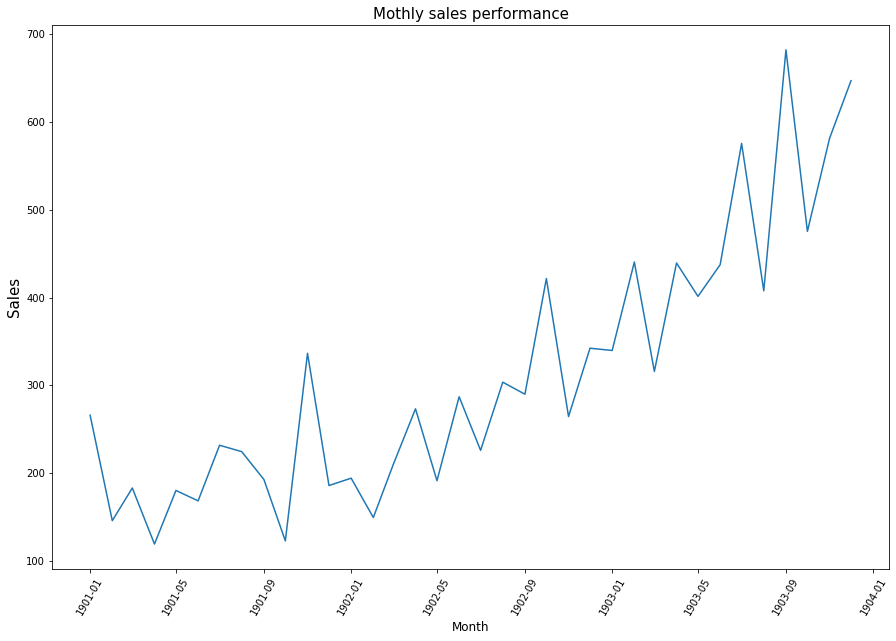

In [10]:
plt.figure(figsize=(15,10))
plt.plot(data)
plt.title('Mothly sales performance', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales', fontsize=15)
plt.xticks(rotation=60)
plt.show()


We see that the series is not stationary\
lets check the stationarity of the series.

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def test_stationary(data):
    #getting the rolling mean and the rolling std of the series
    roll_mean=data.rolling(3).mean()
    roll_std=data.rolling(3).std()   

    #plotting 
    plt.figure(figsize=(13,10))
    plt.plot(data, color='blue', label='Original_Series')
    plt.plot(roll_mean, color='red', label='Rolling mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.title('Original Series Vs. Rolling Mean and Rolling std')
    plt.xlabel('month')
    plt.ylabel('Sales Value')
    plt.xticks(rotation=60)
    plt.legend()
    plt.show()
    
    #Dickey fuller Test
    print("Dickey Fuller Test:")
    dftest = adfuller(data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('Critical values')
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
    
   

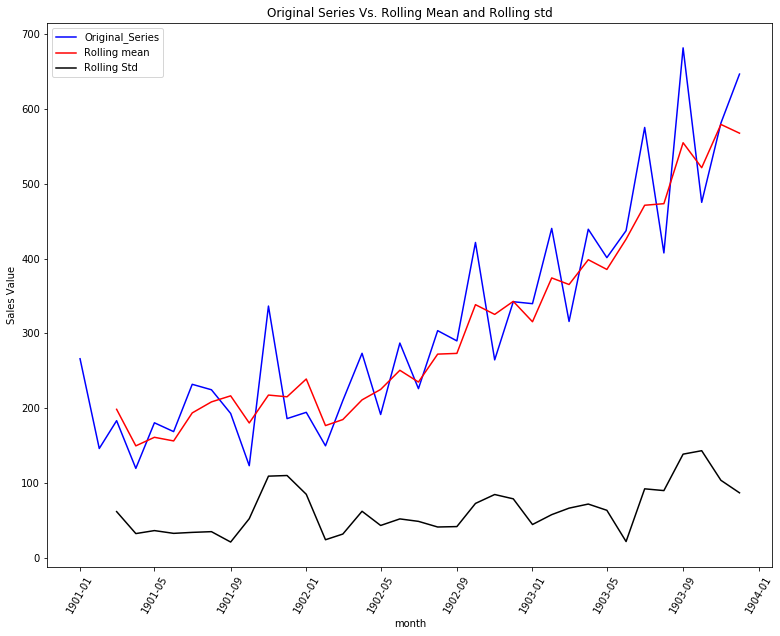

Dickey Fuller Test:
Critical values
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [13]:
test_stationary(data['Sales'])

We see the time series is not stationarey the rolling mean is increasing also the standard deviation. The test statistic 3.06, way higher than the critical value.

In [14]:
#splitting into train and test set
X=data.values
train, test= X[0:-12], X[-12:]

#### Presistant model forecaste

In [15]:
history=[x for x in train]
predictions=list()

In [16]:
for i in range(len(test)):
    predictions.append(history[-1])
    history.append(test[i])


In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
RMSE=np.sqrt(mean_squared_error(test, predictions))
print('RMSE', RMSE)

RMSE 136.76131884905664


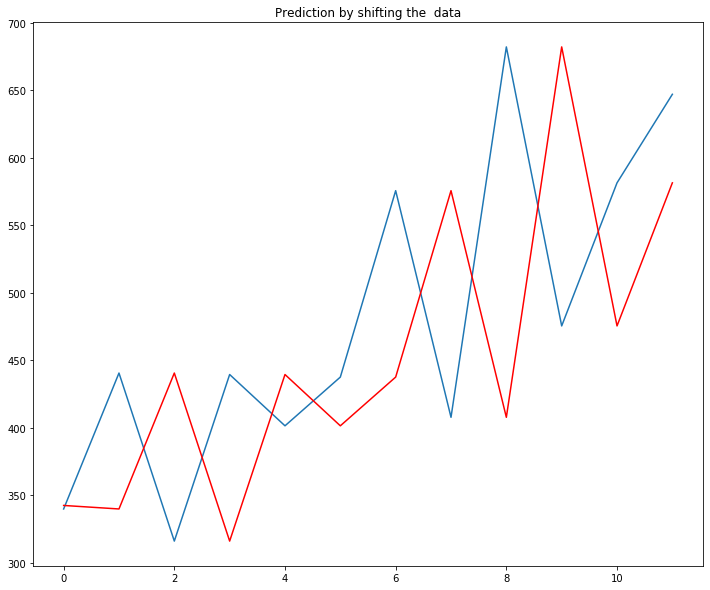

In [19]:
plt.figure(figsize=(12,10))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('Prediction by shifting the  data')
plt.show()

### Time series to stationary

In [20]:
data_diff=data.diff()

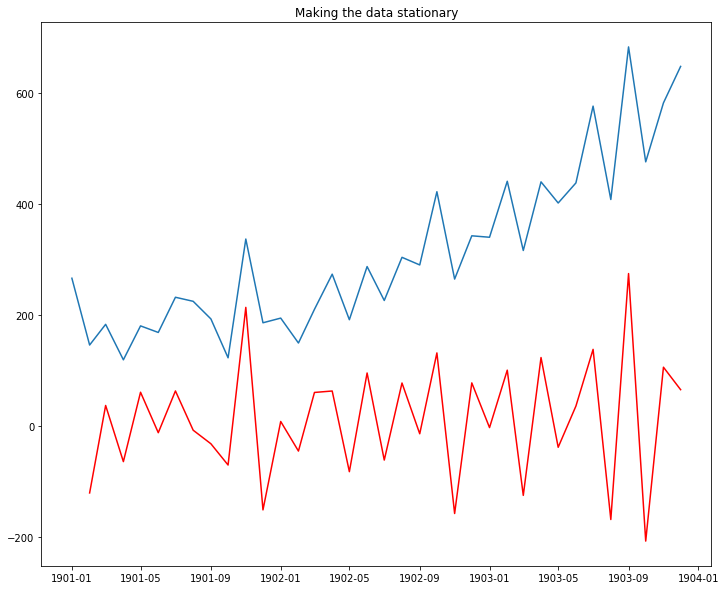

In [21]:
plt.figure(figsize=(12,10))
plt.plot(data)
plt.plot(data_diff, color='red')
plt.title('Making the data stationary')
plt.show()

In [22]:
data_diff.head()

,Sales
Date,
1901-01-01,NaN
1901-02-01,-120.1
1901-03-01,37.2
1901-04-01,-63.8
1901-05-01,61.0


Auto correlation plot

In [23]:
from pandas.plotting import autocorrelation_plot

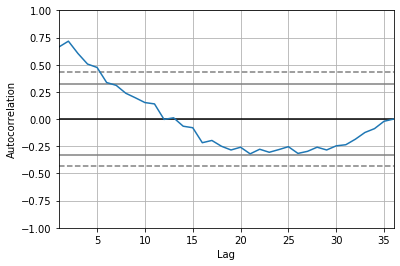

In [24]:
autocorrelation_plot(data)
plt.show()

There is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

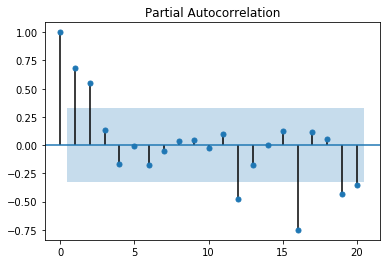

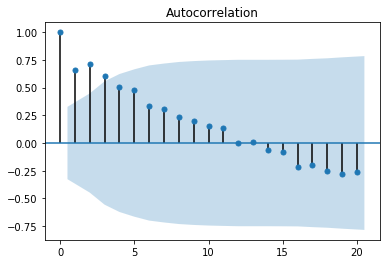

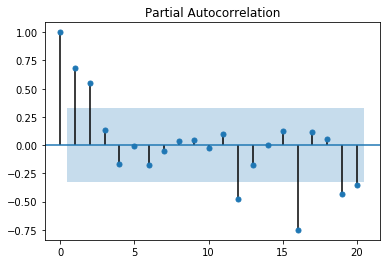

In [26]:
#plt.figure(figsize=(15,12))
plot_acf(data, lags=20)
plot_pacf(data, lags=20)

#### Arima Model

In [27]:
from statsmodels.tsa.arima_model import ARIMA

In [28]:
model= ARIMA(train, order=(3,1,0))
model_fit=model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   23
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -127.046
Method:                       css-mle   S.D. of innovations             58.762
Date:                Mon, 18 May 2020   AIC                            264.092
Time:                        11:19:26   BIC                            269.769
Sample:                             1   HQIC                           265.519
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4920      4.525      1.435      0.168      -2.376      15.360
ar.L1.D.y     -0.8935      0.198     -4.523      0.000      -1.281      -0.506
ar.L2.D.y     -0.5338      0.262     -2.040      0.0

<Figure size 864x720 with 0 Axes>

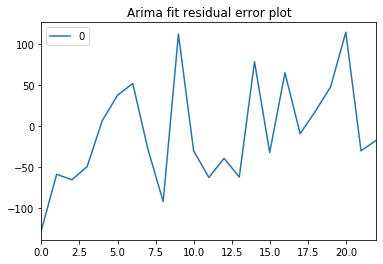

In [29]:
plt.figure(figsize=(12,10))
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('Arima fit residual error plot')
plt.show()

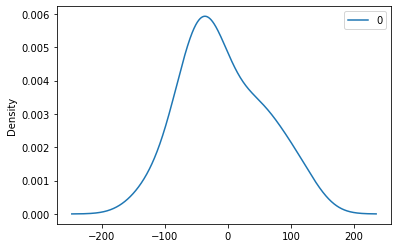

In [30]:
residuals.plot(kind='kde')

In [31]:
residuals.describe()

,0
count,23.000000
mean,-7.445129
std,63.832905
min,-126.592024
25%,-54.114814
50%,-28.507869
75%,42.715416
max,114.434755


### Forcast

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
history=[x for x in train]
pred = list()

In [38]:
for i in range(len(test)):
    model=ARIMA(history, order=(3,1,3))
    model_fit=model.fit(disp=0)
    forcast=model_fit.forecast()
    yhat=forcast[0]
    pred.append(yhat)
    obs=test[i]
    history.append(obs)
    #print('predicted={}, expected={}'.format(prediction, obs))
RMSE=np.sqrt(mean_squared_error(pred, test))
print('RMSE=',RMSE)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

No handles with labels found to put in legend.


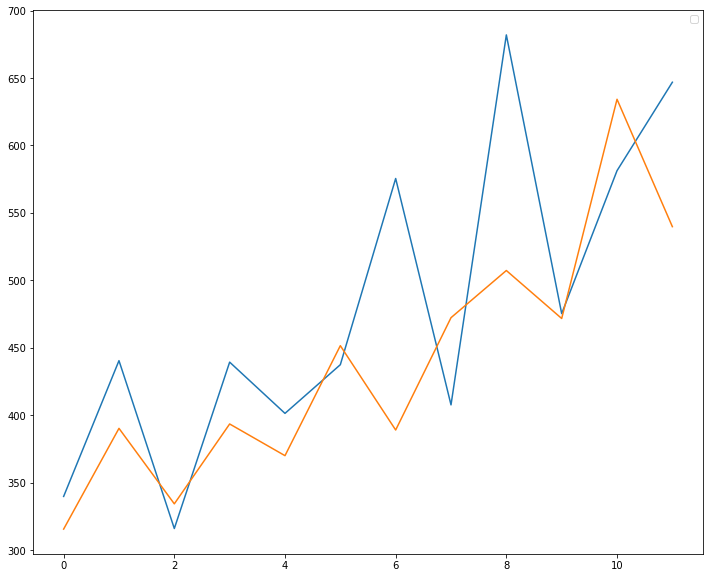

In [35]:
plt.figure(figsize=(12,10))
plt.plot(test)
plt.plot(pred)
plt.legend()

In [36]:
forcast

(array([539.78624032]),
 array([65.79585942]),
 array([[410.82872552, 668.74375512]]))

In [37]:
np.sqrt(6958.325)

83.41657509152482